In [11]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# data 
df = pd.read_table('https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat',
                  names =['Frequency','Angle of attack','Chord length','Free-stream','thickness','level'])
df.describe()

,Frequency,Angle of attack,Chord length,Free-stream,thickness,level
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


In [9]:
df.head()

,Frequency,Angle of attack,Chord length,Free-stream,thickness,level
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


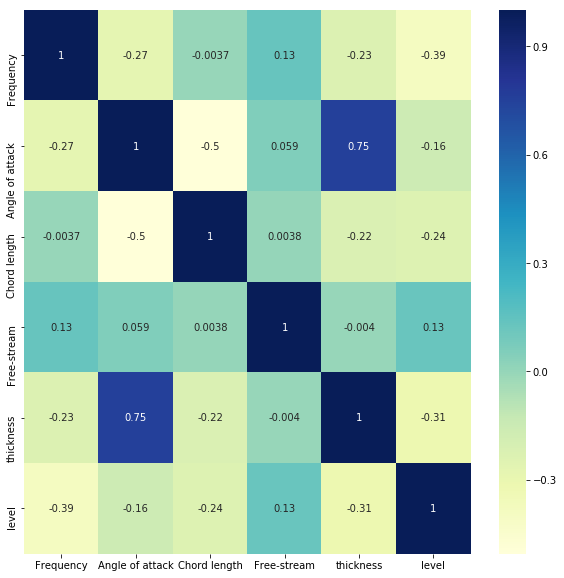

In [17]:
plt.figure( figsize=(10, 10))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu")

<Figure size 720x720 with 0 Axes>

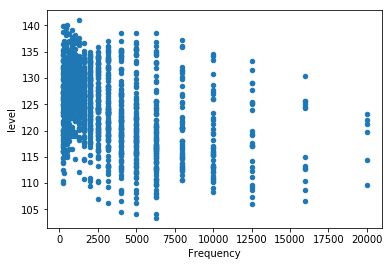

In [19]:
plt.figure( figsize=(10, 10))
df.plot.scatter(x='Angle of attack', y='thickness')